In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

from src.utils import util, data_loaders
from src.utils.domain_split import hyperplane_split
from src.model import MLP
from src.train_test import fit_regr, test_regr

# seed = npr.randint(10000)
seed = 2345
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
df = pd.read_csv("../../data/regression/concrete.csv", index_col=0)
df.head()

,cement,furnace_slag,fly_ash,water,super_plasticizer,coarse_agg,fine_agg,age,compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
D = df.values
dom_idx, OOD_idx = hyperplane_split(D, OOD_size=0.2, verbose=1, seed=seed)
df[dom_idx].head()

Found random direction n = [-0.33095581  0.61535381 -0.39724036  0.24727086  0.17775918  0.3997461
 -0.18732973 -0.25627803 -0.02643909]
Found split with ratio r = 0.2


,cement,furnace_slag,fly_ash,water,super_plasticizer,coarse_agg,fine_agg,age,compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [4]:
# Minmax scaling for better network performace
scaler = MinMaxScaler()
D = df[dom_idx].values
D = scaler.fit_transform(D)

# Split in-domain data to data and labels
X, y = D[:,:-1], D[:,-1]

# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Separate OOD data
OOD = df[OOD_idx].values
OOD = scaler.transform(OOD)         # need to also transform it to be compatible with the NN.
X_OOD, y_OOD = OOD[:,:-1], OOD[:,-1]

# Hyperparameters
n_features = X_train.shape[1]
n_classes = 1
n_hidden_1 = 100
n_hidden_2 = 30
network = [n_hidden_1, n_hidden_2]
activation = 'abs'
n_epochs = 10000
learning_rate = 0.0001
weight_decay = 1e-5
batch_size = 64

# Transformation required for regression problem
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_OOD = y_OOD.reshape(-1, 1)

# Tensor datasets
train_dataset = data_loaders.create_torch_dataset(X_train, y_train, to_LongTensor=False)
test_dataset = data_loaders.create_torch_dataset(X_test, y_test, to_LongTensor=False)
OOD_dataset = data_loaders.create_torch_dataset(X_OOD, y_OOD, to_LongTensor=False)

# Data loaders on gpu
train_loader = data_loaders.create_loader(train_dataset, batch_size, device)
test_loader = data_loaders.create_loader(test_dataset, batch_size, device)
OOD_loader = data_loaders.create_loader(OOD_dataset, batch_size, device)

### Abs

In [5]:
activation = 'abs'

Average Train MSE: 0.00046


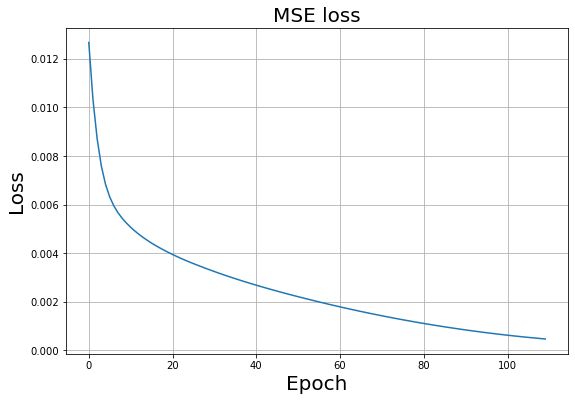

Average test MSE = 0.00069
Average OOD loss = 0.0078583649
Average OOD loss to train loss ratio:  17.057
Average OOD loss to test loss ratio:  11.461


In [6]:
model = MLP(n_features, 1, network, activation, batch_norm=True).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train
train_losses = fit_regr(model, loss_function, optimizer, train_loader, 
    n_epochs=n_epochs, verbose=0, early_stopping='dev', return_losses=True)
avg_train_loss = train_losses[-1]

print(f"Average Train MSE: {avg_train_loss:.5f}")  

plt.figure(figsize=(9,6))
plt.plot(train_losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title("MSE loss", fontsize=20)
plt.show()

avg_test_loss = test_regr(model, loss_function, test_loader, return_loss=True)

print(f"Average test MSE = {avg_test_loss:.5f}")   

avg_OOD_loss = test_regr(model, loss_function, OOD_loader, return_loss=True)

print(f"Average OOD loss = {avg_OOD_loss:.10f}")  
print(f"Average OOD loss to train loss ratio: {avg_OOD_loss / avg_train_loss : .3f}")
print(f"Average OOD loss to test loss ratio: {avg_OOD_loss / avg_test_loss : .3f}")

### ReLU

In [8]:
activation = 'relu'

In [9]:
model = MLP(n_features, 1, network, activation, batch_norm=True).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

Loss has stopped decreasing after epoch 537 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE: 0.00002
Total Train MSE: 0.01339


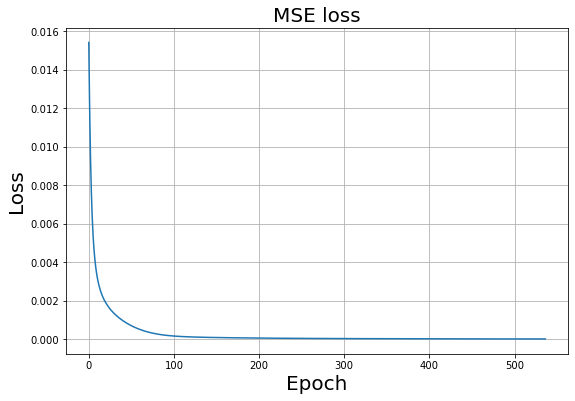

In [10]:
train_losses = fit_regr(model, loss_function, optimizer, train_loader, n_epochs=n_epochs,
                        verbose=1, early_stopping='train', return_losses=True)
avg_train_loss = train_losses[-1]

print(f"Average Train MSE: {avg_train_loss:.5f}")
print(f"Total Train MSE: {len(X_train) * avg_train_loss:.5f}")

plt.figure(figsize=(9,6))
plt.plot(train_losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title("MSE loss", fontsize=20)
plt.show()

In [11]:
avg_test_loss = test_regr(model, loss_function, test_loader, return_loss=True)

print(f"Average test MSE = {avg_test_loss:.5f}")   
print(f"Total test MSE: {len(X_test) * avg_train_loss:.5f}")

Average test MSE = 0.00041
Total test MSE: 0.00335


In [12]:
avg_OOD_loss = test_regr(model, loss_function, OOD_loader, return_loss=True)

print(f"Average OOD loss = {avg_OOD_loss:.10f}")  
print(f"Average OOD loss to train loss ratio: {avg_OOD_loss / avg_train_loss : .3f}")
print(f"Average OOD loss to test loss ratio: {avg_OOD_loss / avg_test_loss : .3f}")

Average OOD loss = 0.0025592010
Average OOD loss to train loss ratio:  126.000
Average OOD loss to test loss ratio:  6.205


In [31]:
def pipeline(X_train, X_test, y_train, y_test, verbose=0):
    
    # Transformation required for regression problem
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # Tensor datasets
    train_dataset = data_loaders.create_torch_dataset(X_train, y_train, to_LongTensor=False)
    test_dataset = data_loaders.create_torch_dataset(X_test, y_test, to_LongTensor=False)

    # Data loaders on gpu
    train_loader = data_loaders.create_loader(train_dataset, batch_size, device)
    test_loader = data_loaders.create_loader(test_dataset, batch_size, device)

    # Model setup
    model = MLP(n_features, 1, network, activation).to(device)

    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # fit function optionally returns a list with the epoch-wise losses
    train_loss = fit_regr(model, loss_function, optimizer, train_loader, 
                 n_epochs=n_epochs, verbose=1, early_stopping=True, return_losses=True) 
    test_loss = test_regr(model, loss_function, test_loader, verbose=0, return_loss=True) 
    
    if verbose:
        print(f"Average Train MSE Loss: {train_loss[-1] : .10f}")
        print(f"Average Test MSE Loss : {test_loss : .10f}" )

    return train_loss, test_loss                 # train loss is a list, test loss is a float
 


Training on fold no. 1
Loss has stopped decreasing after epoch 152 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE Loss:  0.0001394783
Average Test MSE Loss :  0.0032228815

Training on fold no. 2
Loss has stopped decreasing after epoch 179 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE Loss:  0.0001291957
Average Test MSE Loss :  0.0037405792

Training on fold no. 3
Loss has stopped decreasing after epoch 169 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE Loss:  0.0001569484
Average Test MSE Loss :  0.0030567419

Training on fold no. 4
Loss has stopped decreasing after epoch 164 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE Loss:  0.0001339548
Average Test MSE Loss :  0.0009278679

Training on fold no. 5
Loss has stopped decreasing after epoch 145 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE Loss:  0.0001395873
Average Test MSE Loss :  0.0016236231

Training on fold no. 6
Loss has stopped decreasing after epoch 129 (average of 

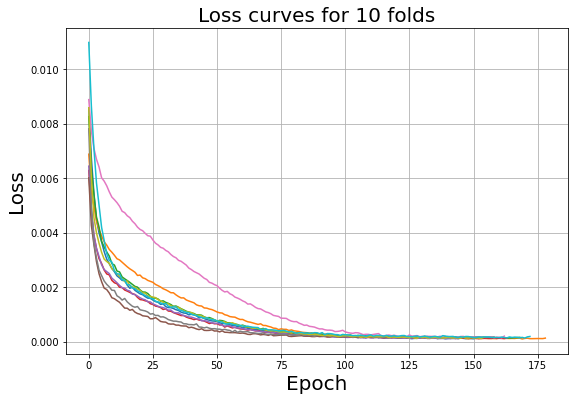

In [32]:
n_splits = 10
kf = KFold(n_splits)

train_losses = np.zeros(n_splits)
test_losses = np.zeros(n_splits)
train_losses_plot = []                           # for plotting loss curves
for i, (train_index, test_index) in enumerate(kf.split(X)):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("\nTraining on fold no. %d" %(i+1))
    epoch_wise_train_losses, test_losses[i] = pipeline(X_train, X_test, y_train, y_test, verbose=1)
    train_losses[i] = epoch_wise_train_losses[-1]
    train_losses_plot.append(epoch_wise_train_losses)
    
print("\nTrain losses:", train_losses)
print("\nTest losses:", test_losses)

avg_train_loss_k_folds = train_losses.mean() 
avg_test_loss_k_folds = test_losses.mean() 
print(f"\nAvg train loss over all folds: {avg_train_loss_k_folds :.5f}")
print(f"Avg total train loss over all folds: {len(X_train) * avg_train_loss_k_folds :.5f}")
print(f"\nAvg test loss over all folds: {avg_test_loss_k_folds :.5f}")
print(f"Avg total test loss over all folds: {len(X_test) * avg_test_loss_k_folds :.5f}")

plt.figure(figsize=(9,6))
for losses in train_losses_plot:
    plt.plot(losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title(f"Loss curves for {n_splits} folds", fontsize=20)
plt.show()